<a href="https://colab.research.google.com/github/krs-lab/octet-data-parser/blob/main/Parse_Octet_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Load packages and dependencies
### This script generates codon optimized sequences for protein expression
### The script takes:
###   - a FASTA formatted protein sequences
###   - an optomized codon table for the organism of choice
### The output is:
###   - a FASTA formatted file with multiple codon optimized versions of the input sequence

#############################
### Here we simply import various packages

### Pandas and Numpy handle data
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import random
import io

### ipywidgets handles fancy input and output
from ipywidgets import widgets, interact, interactive
from IPython.display import display

### matplotlib for plotting
%matplotlib inline
import matplotlib.pyplot as plt

### scipy for ttest function
from scipy import stats

### re for regex functions
import re

import seaborn as sns
sns.set_theme()

### upload module
from google.colab import files
from IPython.display import display

!pwd
!ls

/content
 ClpC1NTD_FF1338_CMB_20240610_assoc.csv
 ClpC1NTD_FF1338_CMB_20240610_assoc_decimate.csv
 ClpC1NTD_FF1338_CMB_20240610_dissoc.csv
 ClpC1NTD_FF1338_CMB_20240610_dissoc_decimate.csv
 sample_data
'Time Interpolated Data_2024_06_10 12_04_11.csv'
'trimmed_Time Interpolated Data_2024_06_10 12_04_11.csv'


In [ ]:
# @title Import data file.
# Upload files

print("Please upload the exported Octet file below.")

uploaded = files.upload()


Please upload the exported Octet file below.


Saving Time Interpolated Data_2024_06_10 12_04_25.csv to Time Interpolated Data_2024_06_10 12_04_25.csv


This is the file name:
----> Time Interpolated Data_2024_06_10 12_04_25.csv 

This is the experiment name:
----> ClpC1NTD_FF1338_CMB_20240610_run2_3 

The max time is 439.8


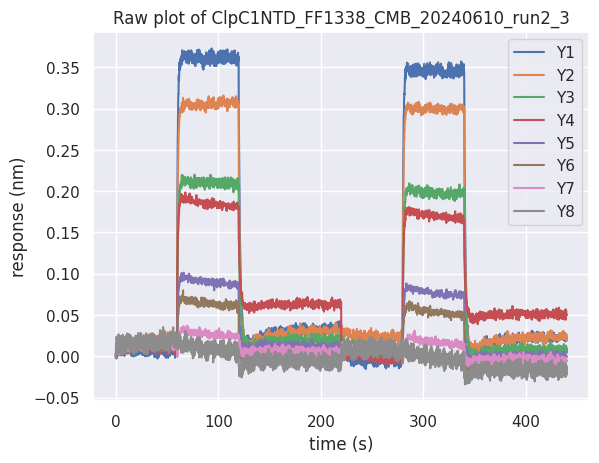

In [ ]:
# @title Digest and plot raw data
print("This is the file name:")
file_name = list(uploaded.keys())[-1]
print("---->",file_name,"\n")

### This can verify that the file was uploaded
#with open(file_name, 'r') as file:
#    content = file.readlines()
#    for line in content[:10]: # display first 10 lines
#          print(line)

### Extract the experiment name from the 4th line in the file
with open(file_name, 'r') as file:
    lines = file.readlines()
    if len(lines) >= 4:
        #print(lines[3])
        match_result = re.search(r"^C.+\\([^\s]+),.+$",lines[3])
        experiment_name = match_result.group(1)
    else:
        print("The file has less than 3 lines.")

print("This is the experiment name:")
print("---->",experiment_name,"\n")

### Trimm off the first few lines and trim off the trailing comma
with open(file_name, 'r') as file:
  lines = file.readlines()
cleaned_lines = [line.rstrip(', \n') + '\n' for line in lines]
trimmed_file_name = 'trimmed_' + file_name
with open(trimmed_file_name, 'w') as trimmed_file:
  trimmed_file.writelines(cleaned_lines[4:])

### Verify that we trimmed what we wanted to
#with open(trimmed_file_name, 'r') as file:
#    content = file.readlines()
#    for line in content[:10]: # display first 10 lines
#          print(line)

# Try reading the CSV with different delimiters and handling bad lines
df = pd.read_csv(trimmed_file_name)

#print("This is the header of the imported data, just to confirm import worked:")
#print(df.head())

# @title Plot raw data
### Now we will migrate the data over into Numpy and plot it, as a sanity check

np_dataset = df.to_numpy()

print("The max time is",np.max(np_dataset[:,0]))

# X and Y data
X = np_dataset[:, 0] # First column is X values
Y = np_dataset[:, 1:] # Remaining columns are Y values

for i in range(Y.shape[1]):
    plt.plot(X, Y[:, i], label=f'Y{i+1}')  # Adjust label as needed

# Add labels and title
plt.xlabel('time (s)')
plt.ylabel('response (nm)')
plt.title('Raw plot of ' + experiment_name)
plt.legend()  # Show legend

# Show plot
plt.grid(True)  # Add grid
plt.show()



In [ ]:
# @title Define binding and dissociation events

print("Please enter the time values to define the beginning and end of the association / dissociation phases.")

layout = widgets.Layout(width='400px', description_width='500px') #adjuts width for a longer description

start_of_association_phase_box = widgets.BoundedFloatText(
    value=0,
    min=0,
    max = np.max(np_dataset[:,0]),
    step=0.1,
    description='Association start:\n',
    disabled=False,
    layout=layout,
    style={'description_width': 'initial'}
)

start_of_dissociation_phase_box = widgets.BoundedFloatText(
    value=0,
    min=0,
    max = np.max(np_dataset[:,0]),
    step=0.1,
    description='Dissociation start:\n',
    disabled=False,
    layout=layout,
    style={'description_width': 'initial'}
)

end_of_dissociation_phase_box =  widgets.BoundedFloatText(
    value = np.max(np_dataset[:,0]),
    min=0,
    max = np.max(np_dataset[:,0]),
    step=0.1,
    description='Dissociation end:\n',
    disabled=False,
    layout=layout,
    style={'description_width': 'initial'}
)

display(start_of_association_phase_box, start_of_dissociation_phase_box, end_of_dissociation_phase_box)



Please enter the time values to define the beginning and end of the association / dissociation phases.


BoundedFloatText(value=0.0, description='Association start:\n', layout=Layout(width='400px'), max=224.0, step=…

BoundedFloatText(value=0.0, description='Dissociation start:\n', layout=Layout(width='400px'), max=224.0, step…

BoundedFloatText(value=224.0, description='Dissociation end:\n', layout=Layout(width='400px'), max=224.0, step…

In [ ]:
# @title Confirm association and dissociation phases.
### Now we create a prompt to copy in the sequence in a textarea box
start_of_association_phase = start_of_association_phase_box.value
start_of_dissociation_phase = start_of_dissociation_phase_box.value
end_of_dissociation_phase = end_of_dissociation_phase_box.value

print("We have captured these values.")
print(start_of_association_phase,start_of_dissociation_phase,end_of_dissociation_phase)

### generate subset data
df_assoc = df.loc[(df['X Values'] >= start_of_association_phase) & (df['X Values'] <  start_of_dissociation_phase)]
df_dissoc = df.loc[(df['X Values'] >= start_of_dissociation_phase) & (df['X Values'] < end_of_dissociation_phase)]

### generate decimated data
df_assoc_decimate = df_assoc.iloc[::10, :]
df_dissoc_decimate = df_dissoc.iloc[::10, :]

#print(df_assoc.head)
#print(df_dissoc.head)
#print(df_assoc_decimate.head)
#print(df_dissoc_decimate.head)

print("Make sure these are the values you entered above!")




We have captured these values.
60.0 119.8 224.0
Make sure these are the values you entered above!


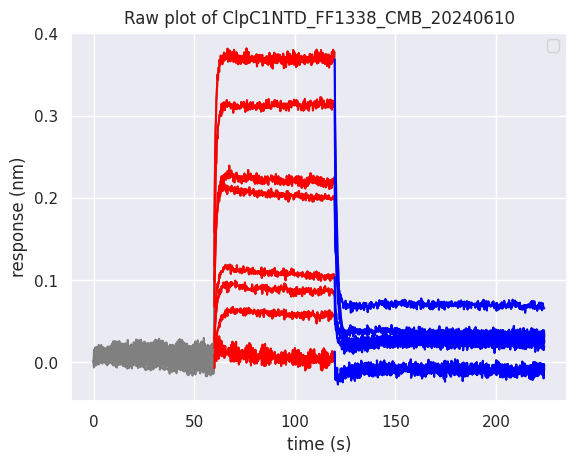

Make sure, in particular, that the dissociation actually
	starts at the right point
If necessary, move back the dissociation start time by 0.2s increments.


In [ ]:
# @title Double check assocation and dissociation ranges.

np_assoc_dataset = df_assoc.to_numpy()
np_dissoc_dataset = df_dissoc.to_numpy()
### we don't need to bother with the decimated data here for plotting
#np_assoc_decimate_dataset = df_assoc_decimate.to_numpy()
#np_dissoc_decimate_dataset = df_dissoc_decimate.to_numpy()

# X and Y data for each dataset
X_full = np_dataset[:, 0] # First column is X values
Y_full = np_dataset[:, 1:] # Remaining columns are Y values
X_assoc = np_assoc_dataset[:, 0] # First column is X values
Y_assoc = np_assoc_dataset[:, 1:] # Remaining columns are Y values
X_dissoc = np_dissoc_dataset[:, 0] # First column is X values
Y_dissoc = np_dissoc_dataset[:, 1:] # Remaining columns are Y values

for i in range(Y_full.shape[1]):
    plt.plot(X_full, Y_full[:, i], color='gray')  # Adjust label as needed
for i in range(Y_assoc.shape[1]):
    plt.plot(X_assoc, Y_assoc[:, i], color='red')  # Adjust label as needed
for i in range(Y_full.shape[1]):
    plt.plot(X_dissoc, Y_dissoc[:, i], color='blue')  # Adjust label as needed

# Add labels and title
plt.xlabel('time (s)')
plt.ylabel('response (nm)')
plt.title('Raw plot of ' + experiment_name)
plt.legend()  # Show legend

# Show plot
plt.grid(True)  # Add grid
plt.show()

#print("maximum time is",np.max(np_dataset[:,0]))

print("Make sure, in particular, that the dissociation actually\n\tstarts at the right point")
print("If necessary, move back the dissociation start time by 0.2s increments.")


In [ ]:
# @title Output files.

### adjust X to start at zero
df_assoc['X Values'] = df_assoc['X Values'].subtract(start_of_association_phase)
df_dissoc['X Values'] = df_dissoc['X Values'].subtract(start_of_dissociation_phase)
df_assoc_decimate['X Values'] = df_assoc_decimate['X Values'].subtract(start_of_association_phase)
df_dissoc_decimate['X Values'] = df_dissoc_decimate['X Values'].subtract(start_of_dissociation_phase)

df_assoc.to_csv(experiment_name + '_assoc.csv', index=False)
df_dissoc.to_csv(experiment_name + '_dissoc.csv', index=False)
df_assoc_decimate.to_csv(experiment_name + '_assoc_decimate.csv', index=False)
df_dissoc_decimate.to_csv(experiment_name + '_dissoc_decimate.csv', index=False)

print("Trimmed files have been generated. \nClick on the folder icon to the left to find and download them.")


Trimmed files have been generated. 
Click on the folder icon to the left to find and download them.
